In [1]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.6 MB/s eta 0:00:00


In [2]:
!pip install -U --pre triton
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 9.7 MB/s eta 0:00:00


In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "harshitaskh/ThumbsUp_v2.1" #@param ["harshitaskh/ThumbsUp_v2.1","harshitaskh/ThumbsUp_v1.5", "runwayml/stable-diffusion-v1-5","stabilityai/stable-diffusion-2-1"] {allow-input: true}

In [4]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    scheduler=DPMSolverMultistepScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

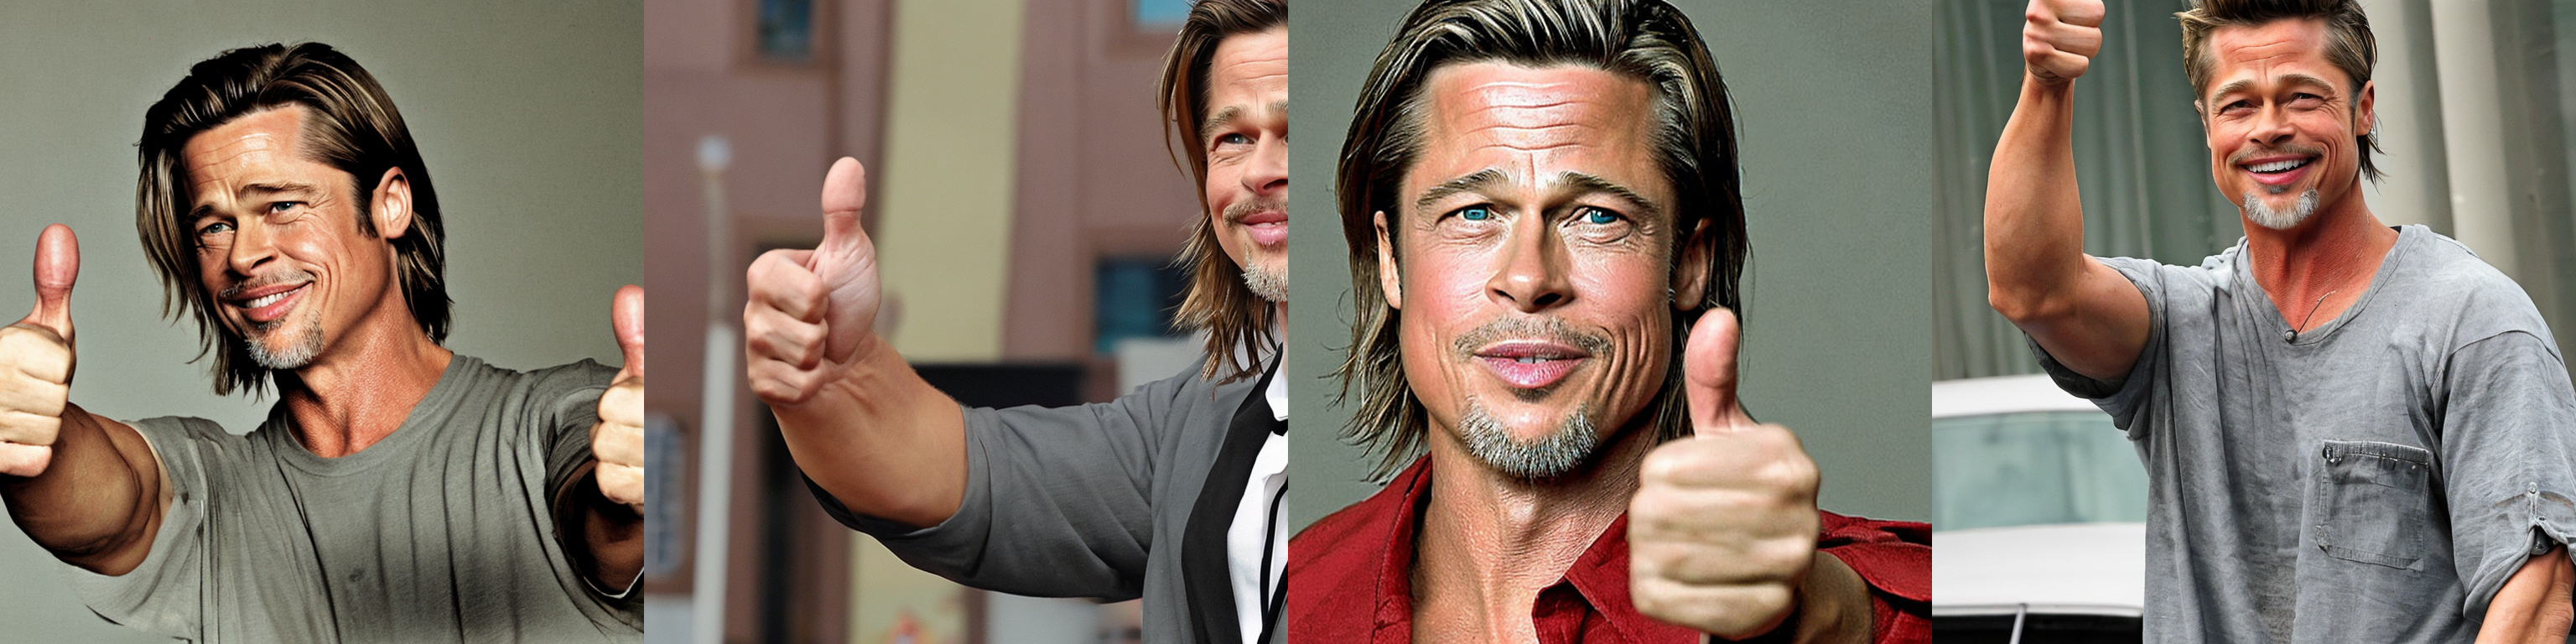

In [15]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt - ( Thumbs Up in this case )

prompt = "Brad Pitt with thumbs up" #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}
all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5 ).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid


In [24]:
all_images[3].save("img3.png")

In [10]:
#@title Run the Stable Diffusion pipeline - manual seed
device="cuda"
generator = torch.Generator(device=device)
height = 512
width = 512

generator = [torch.Generator(device="cuda").manual_seed(28234283493*i) for i in range(4)]

  0%|          | 0/50 [00:00<?, ?it/s]

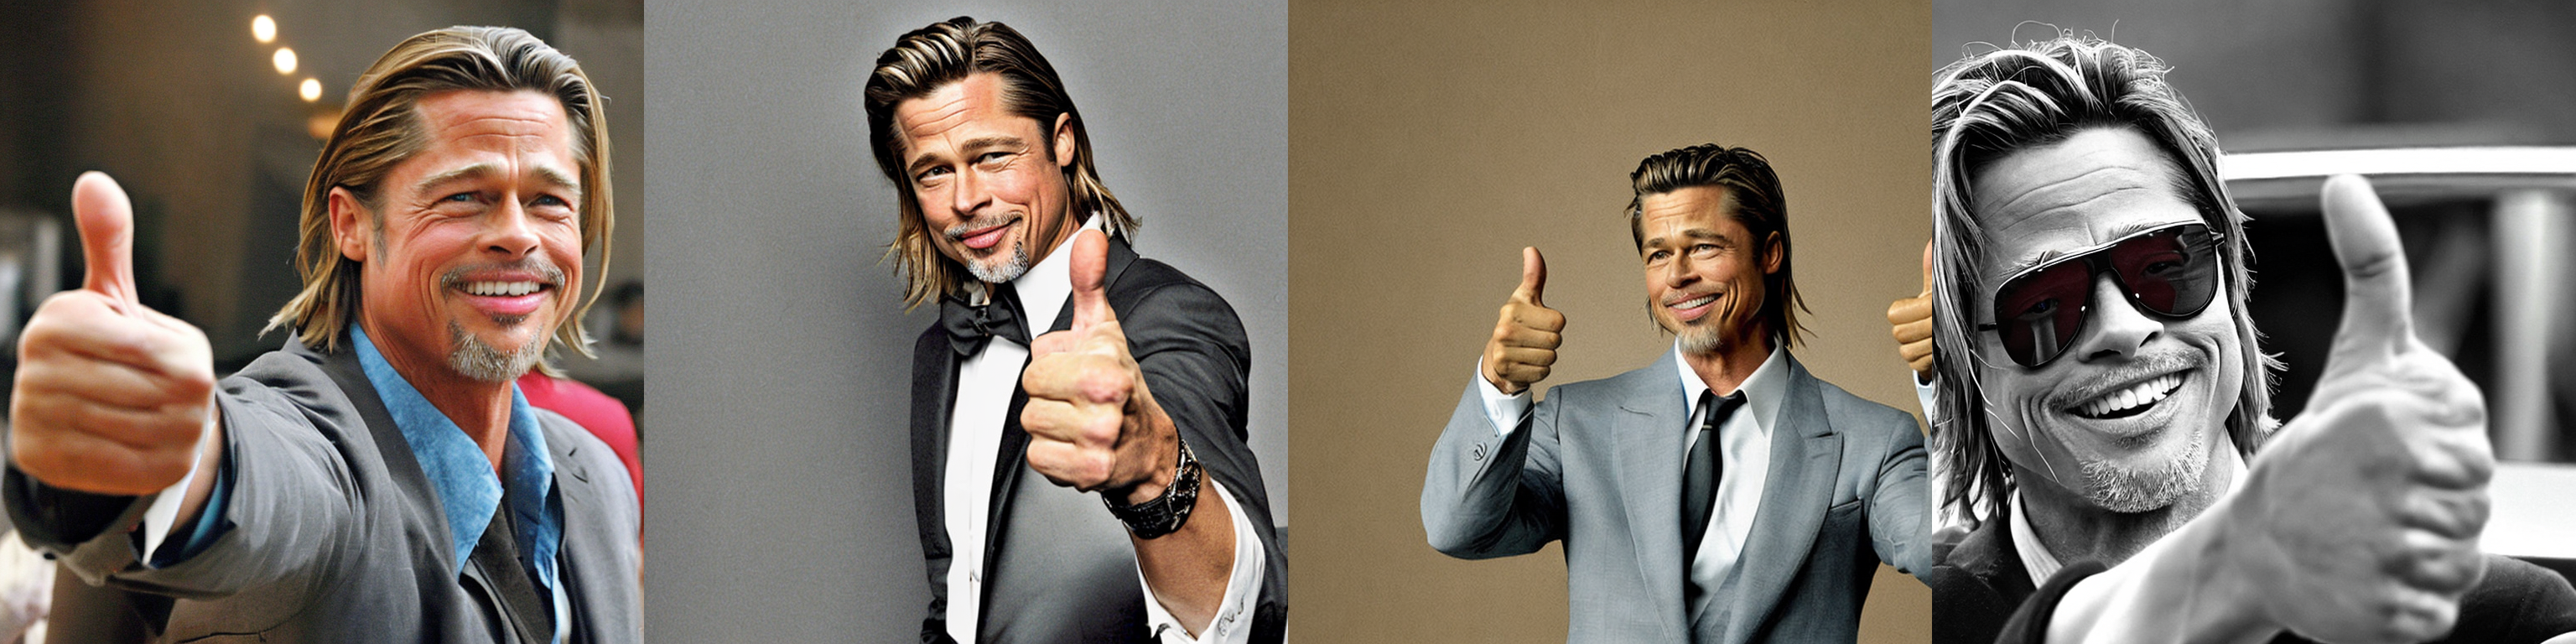

In [11]:
all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, generator = generator, guidance_scale=7.5 ).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid